In [1]:
import torch
import numpy as np 
import scipy

import matplotlib.pyplot as plt
import spatial_maps as sm

from tqdm import tqdm
from models import FFGC
from plotting_functions import *

In [2]:
def smooth(ratemaps, sigma):
    return scipy.ndimage.gaussian_filter(ratemaps, sigma, axes = (-2, -1))

def orientations(peaks, box_size):
    # determine orientations
    distances = np.linalg.norm(peaks - box_size/2, axis=-1)
    closest = np.argmin(distances, axis = -1)
    centered_peaks = peaks - peaks[closest]
    angles = np.arctan2(centered_peaks[:,0], centered_peaks[:,1])[1:7] # flip due to find_peaks
    return angles%(2*np.pi), np.linalg.norm(centered_peaks[1:], axis= -1)
    
def find_peaks(ratemaps, r):
    vals = scipy.ndimage.maximum_filter(ratemaps, 3, axes = (-2, -1))
    masks = ratemaps == vals
    return [r[mask.ravel()] for mask in masks]

def vonmises_kde(data, kappa, n_bins=100):
    # https://stackoverflow.com/questions/28839246/scipy-gaussian-kde-and-circular-data
    bins = np.linspace(-np.pi, np.pi, n_bins)
    x = np.linspace(-np.pi, np.pi, n_bins)
    # integrate vonmises kernels
    kde = np.exp(kappa*np.cos(x[:, None]-data[None, :])).sum(-1)/(2*np.pi*scipy.special.i0(kappa))
    kde /= np.trapz(kde, x=bins)
    return bins, kde

In [3]:
# instantiate feedforward model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = FFGC()
model.to(device)
model = model.load()

In [4]:
# evaluate on 64x64 grid
res = 100
x = np.linspace(-1, 1, res)*2*np.pi
y = np.linspace(-1, 1, res)*2*np.pi
xx, yy = np.meshgrid(x,y)
r = np.stack([xx.ravel(), yy.ravel()], axis = -1)
gs = model(torch.tensor(r.astype("float32"),device = device))
gs = gs.detach().cpu().numpy()
gs = gs.T.reshape(-1,res,res)
gs.shape

(256, 100, 100)

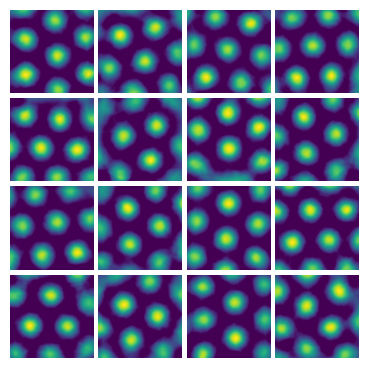

In [5]:
multiimshow(gs[:16], figsize=(4,4), normalize=False);

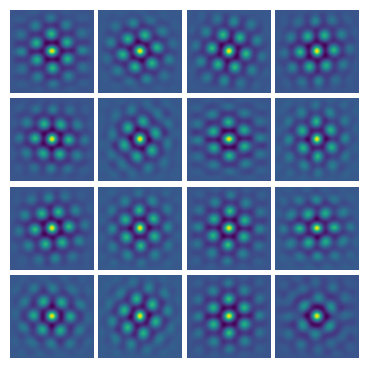

In [6]:
smooth_ratemaps = smooth(gs, 1)
acorrs = np.array([sm.autocorrelation(ratemap) for ratemap in smooth_ratemaps])
multiimshow(acorrs[:16], figsize=(4,4), normalize=False);

In [7]:
grid_score = np.array([sm.gridness(gs[i]) for i in range(len(gs))])

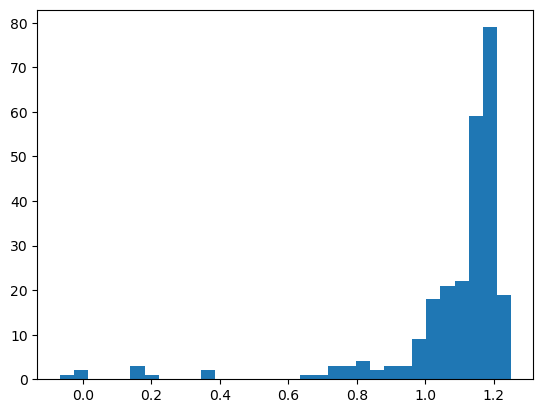

In [8]:
plt.hist(grid_score, bins = 32);

In [9]:
acorrs = acorrs[grid_score > 0.9]
peaks = [sm.find_peaks(acorr) for acorr in acorrs]

In [10]:
thetas = np.array([sm.spacing_and_orientation(peak, acorrs.shape[-1])[1] for peak in peaks])
spacings = np.array([sm.spacing_and_orientation(peak, acorrs.shape[-1])[0] for peak in peaks])
spacings = spacings*4*np.pi/acorrs.shape[-1] # scale to box size

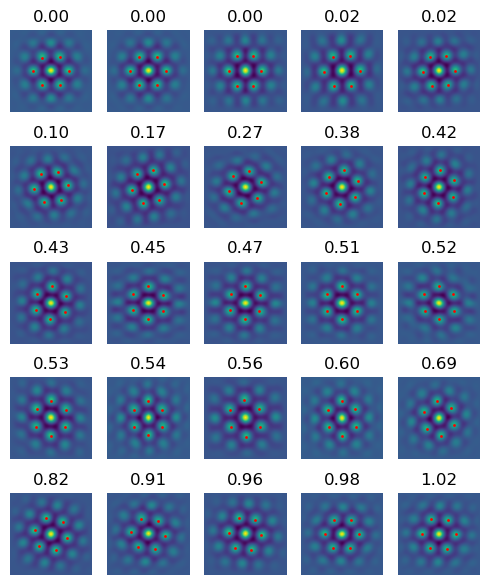

In [11]:
orientation_sorting = np.argsort(thetas)
sorted_maps = acorrs[orientation_sorting]
plot_peaks = [peaks[ind] for ind in orientation_sorting]

ns = 5 # ns x ns grid of unit ratemaps
increment = len(thetas) // (ns**2)
count = 0
fig, ax = plt.subplots(ns,ns, figsize = (5,6))
for i in range(ns**2):
    im = ax[i//ns,i%ns].imshow(sorted_maps[count], origin = "lower")
    ax[i//ns,i%ns].scatter(plot_peaks[count][1:7][:,1], plot_peaks[count][1:7][:,0], c = "r", s = 1)
    ax[i//ns,i%ns].axis("off")
    ax[i//ns,i%ns].set_title(f"{thetas[orientation_sorting][count]%(np.pi/3):.2f}")
    count += increment
plt.tight_layout()

In [12]:
theta_bins = np.linspace(0, np.pi/3, 32, endpoint=False)
counts = np.histogram(thetas, bins = theta_bins)[0]

In [13]:
theta_shift = 6*thetas - np.pi # shift and stretch for von Mises 
v_bins, v_kde = vonmises_kde(theta_shift, 10*np.pi, n_bins = 100)
v_bins = (v_bins + np.pi)/6 # shift back to [0, pi/3]
v_kde = v_kde*6 # re-normalize

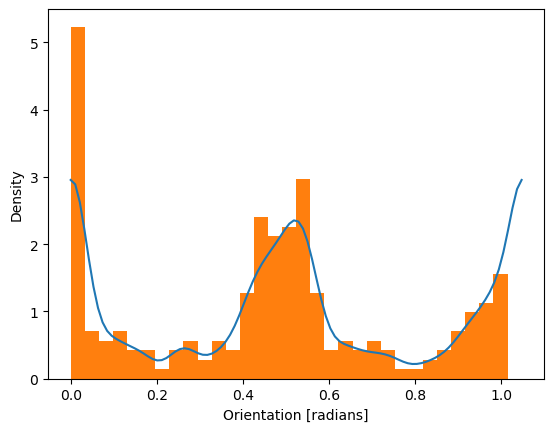

In [14]:
plt.plot(v_bins, v_kde) # revert to [0, pi/3]
plt.hist(thetas, theta_bins, density = True);
plt.xlabel("Orientation [radians]");
plt.ylabel("Density");

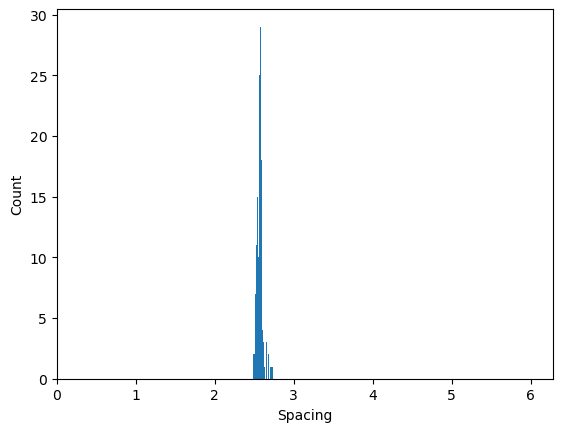

In [15]:
plt.hist(spacings, bins = 32);
plt.xlim([0, 2*np.pi])
plt.xlabel("Spacing");
plt.ylabel("Count");